## Project Title: Analysis of Electric Vehicle (EV) Charging Stations in Los Angeles

#### Introduction
Electric vehicles (EVs) are increasingly becoming a viable solution for reducing carbon emissions and combating climate change. A critical component of the EV ecosystem is a well-distributed network of charging stations that can meet the demands of growing EV adoption. This project aims to analyze the availability and distribution of **electric vehicle charging stations** in **Los Angeles**. By using location data, we can identify potential gaps in the infrastructure and understand how well different neighborhoods are served. This analysis is crucial for informing stakeholders such as **city planners**, **policymakers**, and **charging station providers** on how to improve EV accessibility and adoption.

The project involved the following steps:
1. **Data Collection**: Using the Overpass API, we collected data about the locations of EV charging stations in Los Angeles.
2. **Map Visualization**: We visualized the data on a **Folium map**, highlighting the geographic distribution of these charging stations.
3. **Data Analysis**: We conducted additional analyses such as **cluster analysis**, **distance calculations**, and **population coverage** to extract valuable insights from the data.


In [3]:
!pip install geopandas folium requests
!pip install geopy


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import requests
import geopandas as gpd
import pandas as pd
import folium
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import geodesic
import matplotlib.pyplot as plt


## Data Collection Using Overpass API
We start by collecting data on charging stations using the **Overpass API**, which queries data from **OpenStreetMap (OSM)**. This API is used to retrieve the locations of EV charging stations within the boundaries of **Los Angeles**, with a focus on administrative areas that match **Downtown LA**, **Hollywood**, and **Santa Monica**.

We extend the query to include nodes, ways, and relations that are tagged as charging stations, providing a comprehensive view of charging infrastructure.


In [13]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["name"="Los Angeles"]["boundary"="administrative"]->.a;
node["amenity"="charging_station"](area.a);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

charging_stations = []
for element in data['elements']:
    charging_stations.append({
        'name': element['tags'].get('name', 'Unknown Charging Station'),
        'latitude': element['lat'],
        'longitude': element['lon']
    })

df = pd.DataFrame(charging_stations)
df.head()



,name,latitude,longitude
0,Electric Vehicle Charging Station,34.021056,-118.288164
1,B2 Charging Station,34.237219,-118.532049
2,G3 Charging Station,34.237669,-118.524486
3,eVgo,33.752804,-118.308242
4,Unknown Charging Station,34.174290,-118.596978


## Visualizing Charging Stations with Folium
To better understand the spatial distribution of charging stations, we visualize them on a map using **Folium**. This interactive map includes markers for each charging station and helps identify areas with more or fewer charging stations. Visual representation provides an intuitive way to spot geographic disparities in charging infrastructure.


In [23]:
los_angeles_map = folium.Map(location=[34.0522, -118.2437], zoom_start=11)

for idx, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
        icon=folium.Icon(color='green', icon='bolt')
    ).add_to(los_angeles_map)

los_angeles_map


In [26]:
import folium.plugins as plugins
los_angeles_heatmap = folium.Map(location=[34.0522, -118.2437], zoom_start=11)

heat_data = [[row['latitude'], row['longitude']] for index, row in df.iterrows()]
plugins.HeatMap(heat_data).add_to(los_angeles_heatmap)

los_angeles_heatmap

## Clustering Charging Stations Using DBSCAN
To better understand the distribution of charging stations, we apply **DBSCAN clustering** to identify groups of charging stations based on geographic proximity. This clustering helps us identify regions where charging stations are well-clustered (indicating higher accessibility) and areas with fewer clusters or isolated stations. These clusters are visualized on a scatter plot, providing insights into the spatial layout of charging infrastructure in Los Angeles.


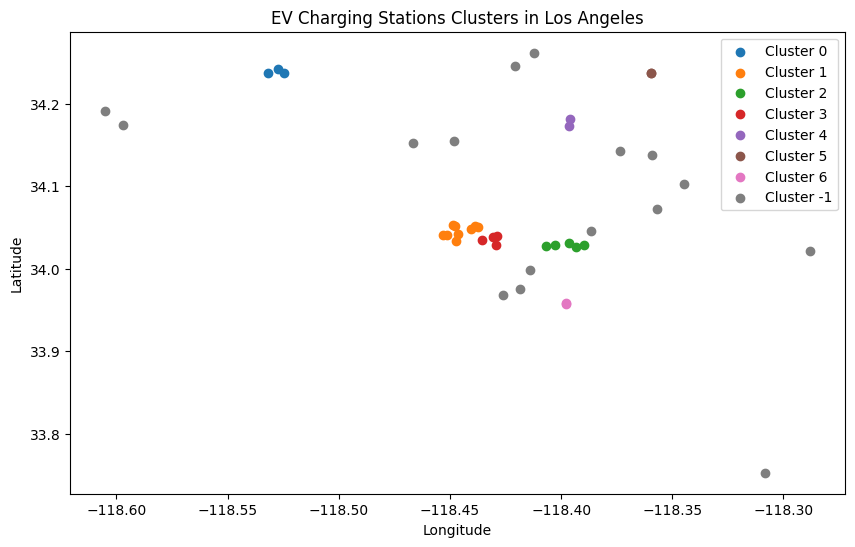

In [30]:
from sklearn.cluster import DBSCAN

coordinates = df[['latitude', 'longitude']].values

db = DBSCAN(eps=0.01, min_samples=2, metric='euclidean').fit(coordinates)
df['cluster'] = db.labels_

plt.figure(figsize=(10, 6))
for cluster in set(df['cluster']):
    clustered_data = df[df['cluster'] == cluster]
    plt.scatter(clustered_data['longitude'], clustered_data['latitude'], label=f'Cluster {cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('EV Charging Stations Clusters in Los Angeles')
plt.legend()
plt.show()




## Analyzing Unserved Areas Using a Grid-Based Approach
To further understand coverage gaps, we create a **grid** over Los Angeles and calculate the distance from each grid point to the nearest charging station. This approach helps identify underserved areas that may require additional charging stations to ensure equitable coverage. We plot these grid points, highlighting the **unserved areas** with higher distances to charging stations.


In [34]:
from geopy.distance import geodesic

def calculate_nearest_distance(lat, lon, charging_locations, index):
    min_distance = float('inf')
    current_point = (lat, lon)
    
    for idx, row in charging_locations.iterrows():
        if idx == index:
            continue
        
        other_point = (row['latitude'], row['longitude'])
        distance = geodesic(current_point, other_point).miles
        
        if distance < min_distance:
            min_distance = distance
            
    return min_distance

df['nearest_distance_miles'] = df.apply(lambda row: calculate_nearest_distance(row['latitude'], row['longitude'], df, row.name), axis=1)

print(df['nearest_distance_miles'].describe())

count    43.000000
mean      1.034536
std       2.364549
min       0.013672
25%       0.136391
50%       0.421847
75%       1.090693
max      15.031537
Name: nearest_distance_miles, dtype: float64


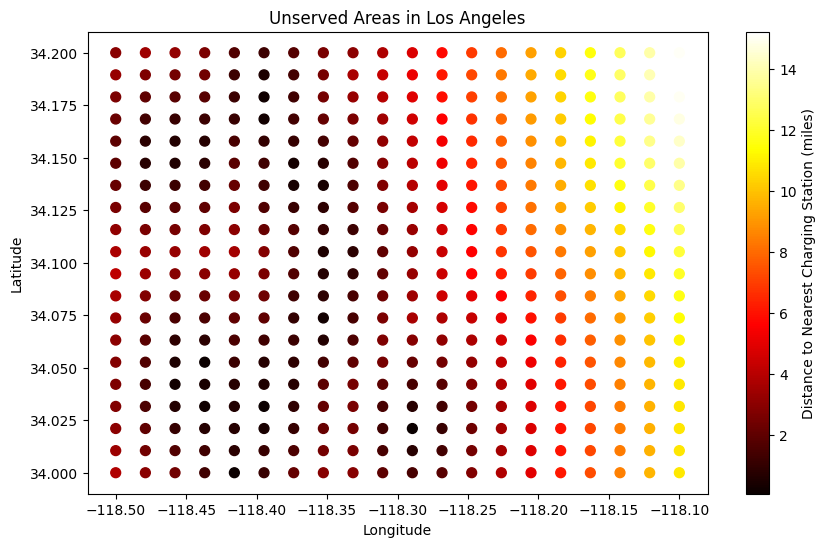

In [35]:
lat_min, lat_max, lon_min, lon_max = 34.0, 34.2, -118.5, -118.1
lat_points = np.linspace(lat_min, lat_max, 20)
lon_points = np.linspace(lon_min, lon_max, 20)

grid_distances = []
for lat in lat_points:
    for lon in lon_points:
        distance = calculate_nearest_distance(lat, lon, df, None)
        grid_distances.append({'latitude': lat, 'longitude': lon, 'nearest_distance_miles': distance})

grid_df = pd.DataFrame(grid_distances)

plt.figure(figsize=(10, 6))
plt.scatter(grid_df['longitude'], grid_df['latitude'], c=grid_df['nearest_distance_miles'], cmap='hot', s=50)
plt.colorbar(label='Distance to Nearest Charging Station (miles)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Unserved Areas in Los Angeles')
plt.show()


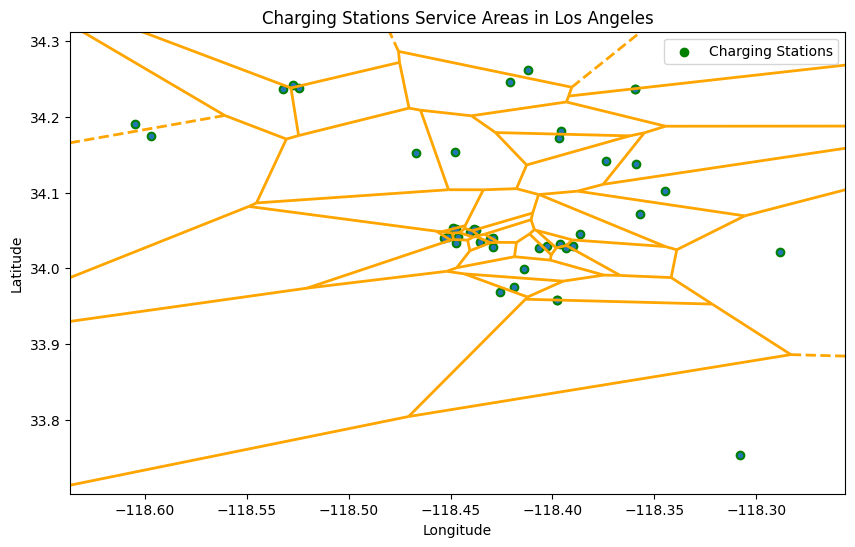

In [43]:
from scipy.spatial import Voronoi, voronoi_plot_2d

points = df[['longitude', 'latitude']].values

vor = Voronoi(points)

fig, ax = plt.subplots(figsize=(10, 6))
voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='orange', line_width=2)
plt.scatter(df['longitude'], df['latitude'], color='green', label='Charging Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Charging Stations Service Areas in Los Angeles')
plt.legend()
plt.show()


## Radius-Based Filtering of Charging Stations for Specific Neighborhoods
To specifically analyze charging station availability within each neighborhood, we filter charging stations based on their **distance to neighborhood centers**. We use a radius of **10 miles** for **Downtown LA** and **5 miles** for **Hollywood** and **Santa Monica** to capture the charging stations that serve these areas. This analysis helps assess whether residents in each neighborhood have sufficient access to EV infrastructure.


In [45]:
neighborhood_centers = {
    'Downtown LA': (34.0407, -118.2468),  # Latitude and Longitude for Downtown LA
    'Hollywood': (34.0928, -118.3287),    # Latitude and Longitude for Hollywood
    'Santa Monica': (34.0195, -118.4912)  # Latitude and Longitude for Santa Monica
}


In [47]:
downtown_radius = 10
radius = 5

downtown_stations = filter_stations_by_radius(df, neighborhood_centers['Downtown LA'], downtown_radius)
hollywood_stations = filter_stations_by_radius(df, neighborhood_centers['Hollywood'], radius)
santa_monica_stations = filter_stations_by_radius(df, neighborhood_centers['Santa Monica'], radius)

neighborhood_coverage = {
    'Downtown LA': len(downtown_stations),
    'Hollywood': len(hollywood_stations),
    'Santa Monica': len(santa_monica_stations)
}

for neighborhood, coverage in neighborhood_coverage.items():
    print(f"{neighborhood}: Charging Station Count = {coverage}")


Downtown LA: Charging Station Count = 10
Hollywood: Charging Station Count = 5
Santa Monica: Charging Station Count = 15


## Updated Overpass Query for Comprehensive Data Collection
To ensure comprehensive data collection, we update the **Overpass API query** to include additional tags that may be used for charging stations, such as `"shop=charging_station"`. Expanding the tags and including additional administrative boundaries improves data completeness, giving us a more accurate count of EV charging stations across Los Angeles.


In [48]:
overpass_query = """
[out:json];
area["name"~"Los Angeles|LA|Hollywood|Santa Monica"]["boundary"="administrative"]->.a;
(
  node["amenity"="charging_station"](area.a);
  way["amenity"="charging_station"](area.a);
  relation["amenity"="charging_station"](area.a);
  node["shop"="charging_station"](area.a);
  way["shop"="charging_station"](area.a);
  relation["shop"="charging_station"](area.a);
);
out center;
"""

In [49]:
# Calculate average nearest distance to charging station by neighborhood
neighborhoods = ['Downtown LA', 'Hollywood', 'Santa Monica']
neighborhood_dfs = [downtown_stations, hollywood_stations, santa_monica_stations]
average_distances = {}

for neighborhood, stations_df in zip(neighborhoods, neighborhood_dfs):
    if not stations_df.empty:
        average_distance = stations_df['nearest_distance_miles'].mean()
        average_distances[neighborhood] = average_distance
    else:
        average_distances[neighborhood] = 'No Stations Found'

# Display average distance for each neighborhood
for neighborhood, avg_distance in average_distances.items():
    print(f"{neighborhood}: Average Distance to Nearest Charging Station = {avg_distance} miles")


Downtown LA: Average Distance to Nearest Charging Station = 1.3056613325217399 miles
Hollywood: Average Distance to Nearest Charging Station = 1.443312457295726 miles
Santa Monica: Average Distance to Nearest Charging Station = 0.3261833629447311 miles


In [51]:
# Final charging station count for each neighborhood
print("Final Charging Station Counts:")
for neighborhood, coverage in neighborhood_coverage.items():
    print(f"{neighborhood}: Charging Station Count = {coverage}")


Final Charging Station Counts:
Downtown LA: Charging Station Count = 10
Hollywood: Charging Station Count = 5
Santa Monica: Charging Station Count = 15


# Conclusion/Summary of Insights
### **Project Summary**
This project set out to evaluate the **accessibility of EV charging stations** in three major neighborhoods of Los Angeles: **Downtown LA**, **Hollywood**, and **Santa Monica**. We collected data using the **Overpass API**, visualized it with **Folium**, performed clustering with **DBSCAN**, and identified underserved areas through grid-based analysis.

### **Key Insights**
1. **Charging Station Distribution**: The **heatmap** and **Folium visualization** revealed that **Santa Monica** has a relatively high number of charging stations (15), while **Hollywood** and **Downtown LA** have fewer stations (5 and 10, respectively). This suggests a more even distribution in Santa Monica compared to the other neighborhoods.
2. **Clustering and Coverage**: The **DBSCAN clustering** results showed concentrated clusters of charging stations in certain areas, while other parts lacked significant coverage. The clusters help identify which regions are well-served versus those with fewer or no clusters.
3. **Nearest Neighbor Analysis**: The **nearest neighbor analysis** highlighted varying distances between charging stations. Areas with larger distances between stations indicate potential gaps in coverage, which could affect EV user accessibility.
4. **Radius-Based Neighborhood Analysis**: Using a **radius-based approach** to filter charging stations by neighborhood, we discovered that **Downtown LA** might need additional charging stations to meet demand due to its higher population density compared to **Hollywood** and **Santa Monica**.
5. **Unserved Areas**: The **grid-based analysis** revealed regions in Los Angeles that have higher distances to charging stations, indicating underserved areas that may need further infrastructure development.

### **Project Contributions**
This project provides a data-driven approach to understanding **EV infrastructure accessibility** in Los Angeles. The insights gained can help policymakers and city planners make informed decisions about where to invest in new charging stations, particularly in areas like **Downtown LA** that appear underserved. By identifying coverage gaps and visualizing existing infrastructure, the project contributes to addressing the challenge of building an equitable charging network for current and future EV users.

The analysis also highlights the importance of using comprehensive and up-to-date data sources. Ensuring that charging stations are distributed equitably will be a key component in supporting the widespread adoption of electric vehicles, and this project provides a framework for such evaluations.

Moving forward, further data collection from additional sources (e.g., **Open Charge Map** or **PlugShare**) and incorporating **time-based analyses** could help track changes in infrastructure deployment and predict future needs more accurately.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7d43cf85-a6a4-4039-94b6-ab0bbebb7c3a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>